## Basic plots that have already been implemented in the G-Colab

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [14]:
## simulation imports
from cone import *

<IPython.core.display.Javascript object>


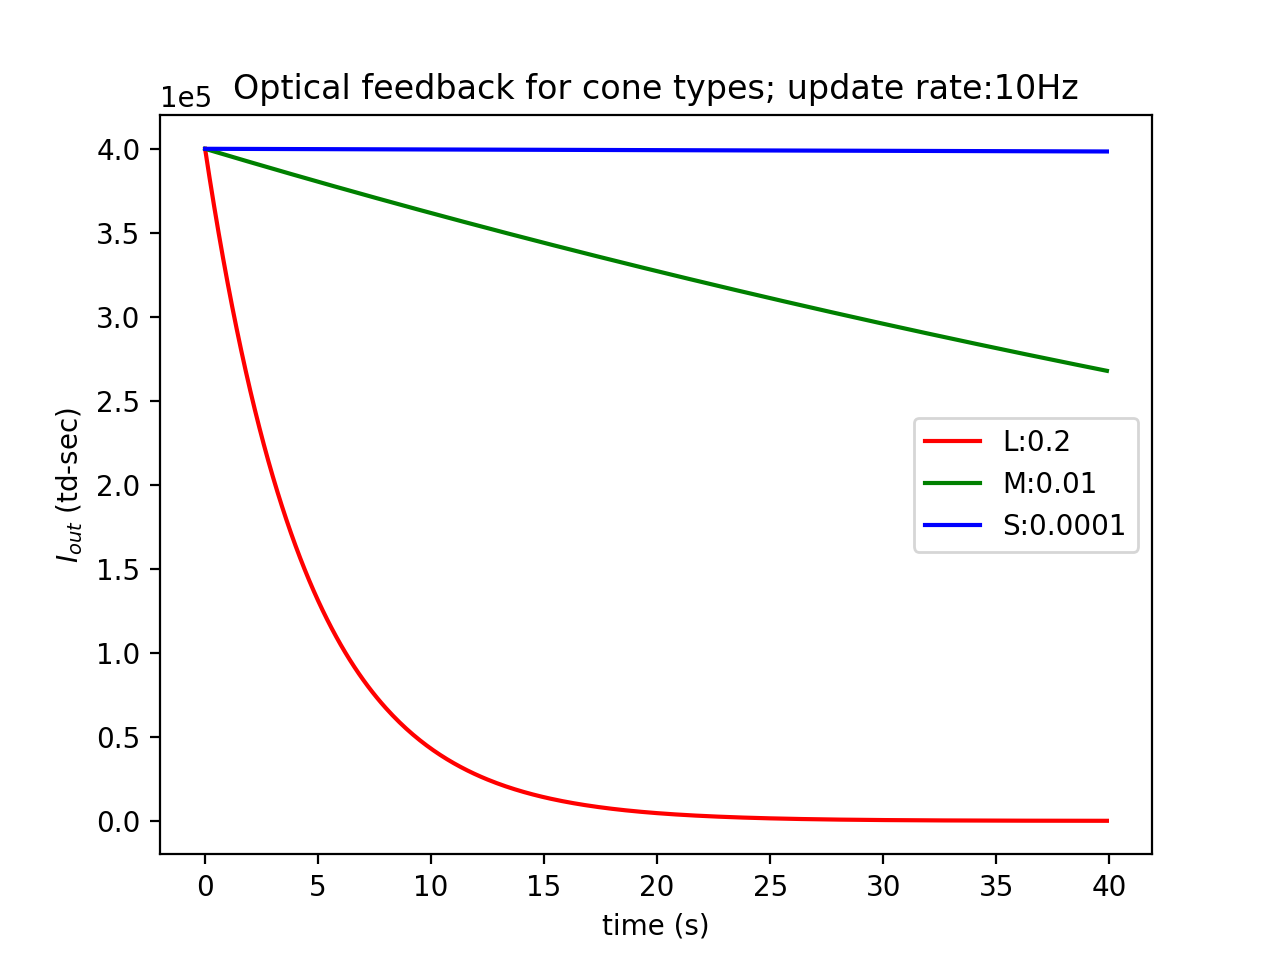

In [4]:
%matplotlib notebook
step_size = 0.1
n_seconds = 40
t = np.arange(0, n_seconds, step_size)
Iin = 4e5*np.ones_like(t)
a_L = 0.2
a_M = 0.01
a_S = 1e-4

plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.plot(t, (1-a_L)**t * Iin, 'r')
plt.plot(t, (1-a_M)**t * Iin, 'g')
plt.plot(t, (1-a_S)**t * Iin, 'b')
plt.legend(['L:%0.1f'%(a_L),'M:%0.2f'%(a_M),'S:%0.4f'%(a_S)])
plt.title('Optical feedback for cone types; update rate:10Hz')
plt.xlabel('time (s)')
plt.ylabel('$I_{out}$ (td-sec)')
plt.show()

## Demonstrate photopigment bleaching dynamics

In [5]:
%matplotlib notebook
n_on = 5
n_off = 195
pulse = ([1]*n_on) + ([0]*n_off)
pulse = pulse * 4
pulse = np.array(pulse)

step_size = 0.05
n_seconds = 40
t = np.arange(0, n_seconds, step_size)
p0 = 1.0
Qe = 3E6
Iin = 4e5*pulse
a_cone = 0.5
a_scatter = 0.95
# dpdt = lambda Iin_ti, Qe, p_ti: -Iin_ti * p_ti / Qe

Iout = []
pt = [p0]
p_ti = p0
for i, ti in enumerate(t):
    p_grad = dpdt(Iin[i], Qe, pt[i])
    p_ti += p_grad * step_size
    pt.append(p_ti)
    Iout.append(compute_reflected_light(Iin[i], a_cone, p_ti, a_scatter=a_scatter))

<IPython.core.display.Javascript object>


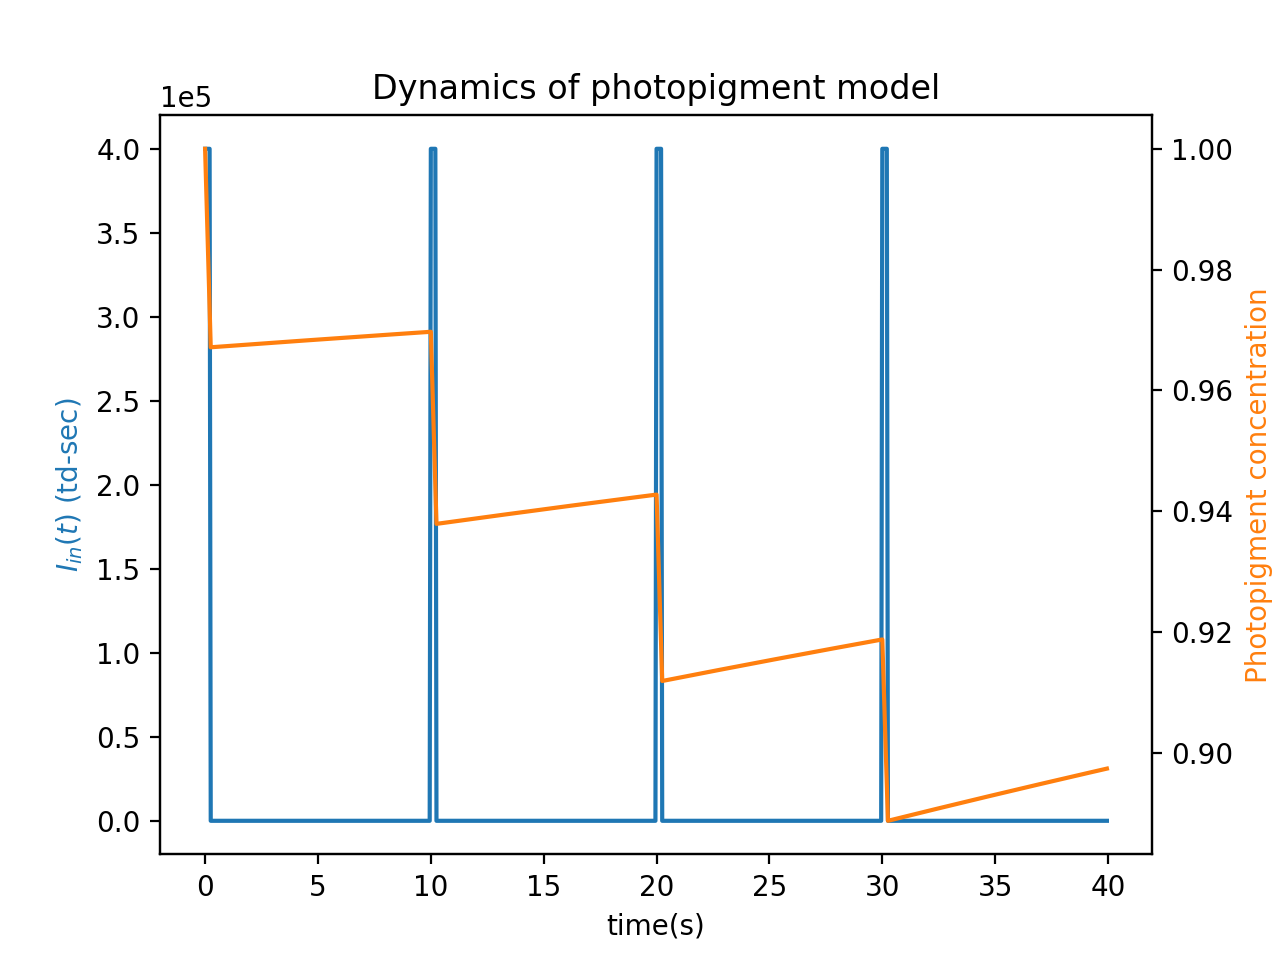

Text(0, 0.5, 'Photopigment concentration')

In [6]:
fig,ax = plt.subplots()
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax.plot(t, Iin, 'tab:blue')
ax.set_xlabel('time(s)')
ax.set_ylabel('$I_{in}(t)$ (td-sec)',color='tab:blue')
plt.title('Dynamics of photopigment model')

ax2=ax.twinx()
ax2.plot(t, pt[:-1],'tab:orange')
ax2.set_ylabel("Photopigment concentration",color='tab:orange')


<IPython.core.display.Javascript object>


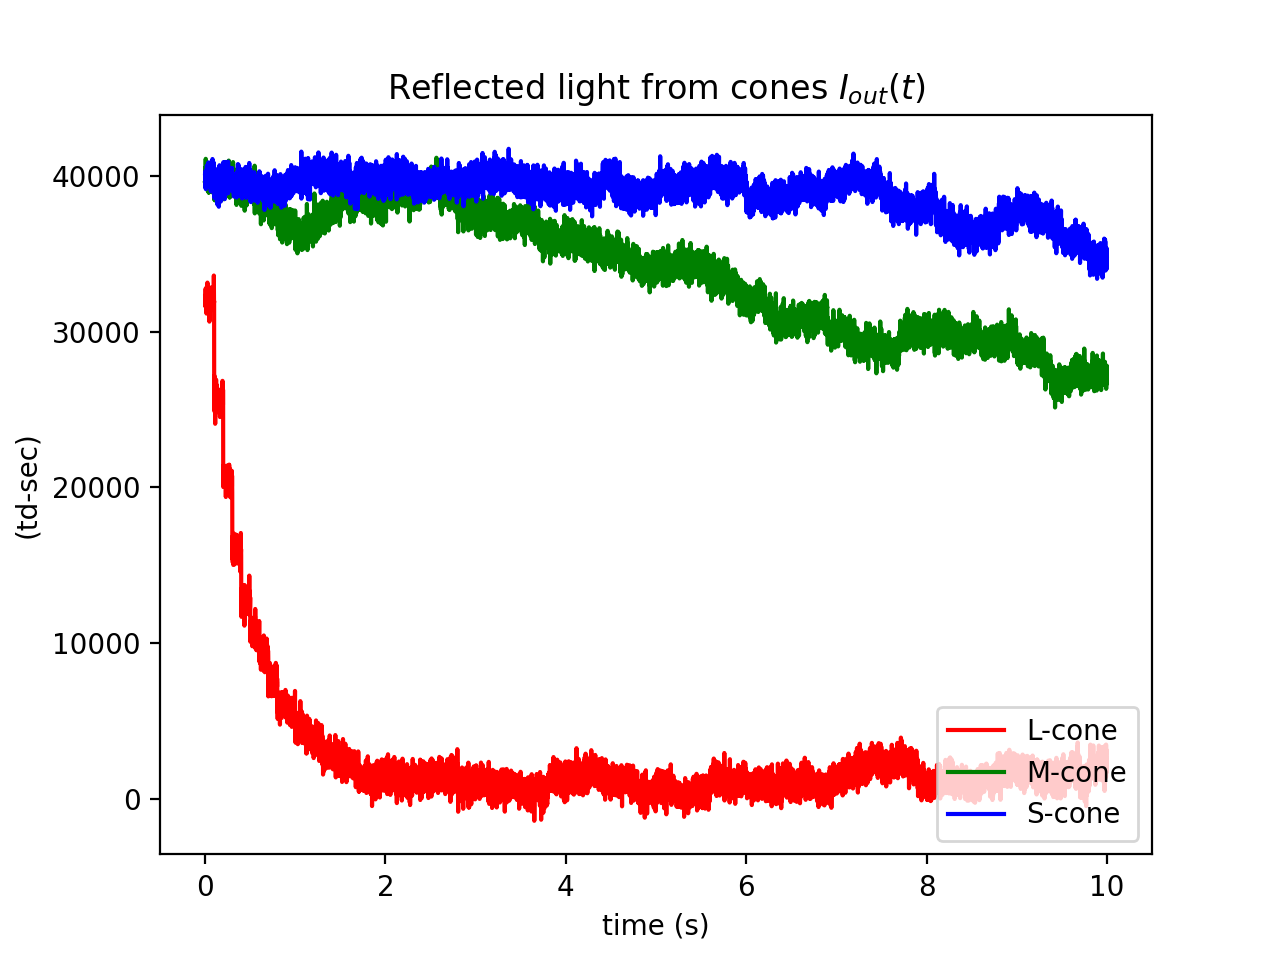

<IPython.core.display.Javascript object>


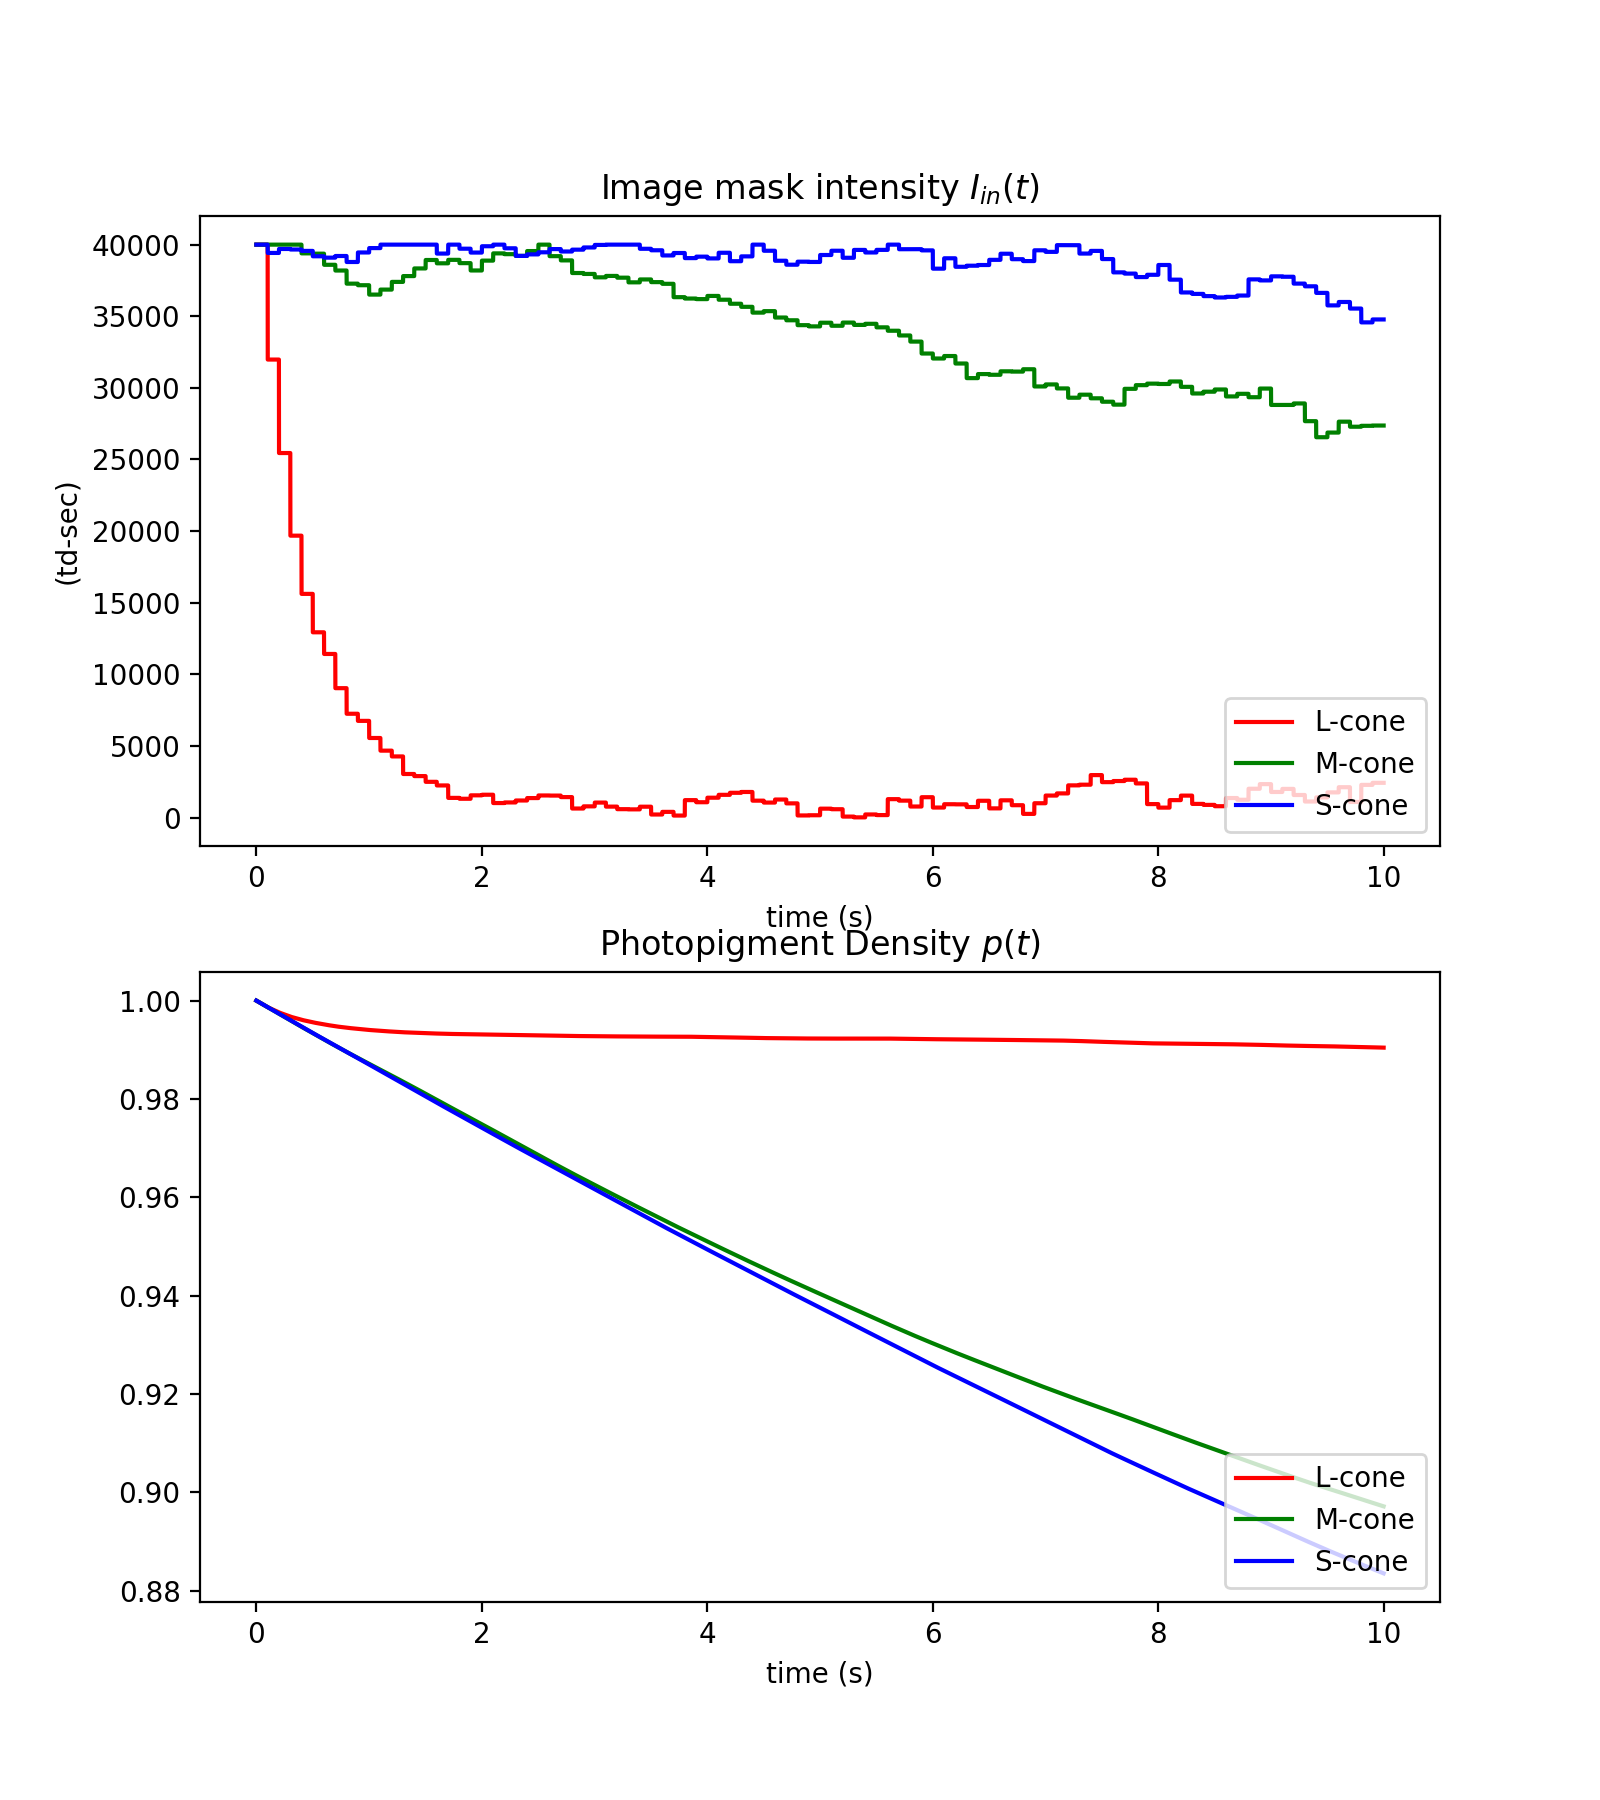

In [7]:
%matplotlib notebook

# np.random.seed(100)
def simulate_experiment(a_cone=0.1):
    update_rate = 0.1    # [s] update rate of Iin(t) = Iout(t-1)
    dt          = 0.001  # [s] simulation rate
    n_seconds   = 10     # [s] total simulation time

    t = np.arange(0, n_seconds, dt)
    update_t = np.arange(update_rate, n_seconds, update_rate)

    p0 = 1.0
    Qe = 3E6
    a_scatter = .995

    Iin_0 = 4e4
    Iin = [Iin_0]
    Iout = []
    
    mu_cone = 0;
    sigma_cone = 0.0;
    mu_m = 250         # [ld-sec]
    sigma_m = 500;    

    pt = [p0]
    p_ti = p0
    updatei = 0;
    for i, ti in enumerate(t):

        # update photopigment concentration
        p_grad = dpdt(Iin[i], Qe, pt[i])
        p_ti += p_grad * dt
        pt.append(p_ti)

        # update output image

        # noise/scatter model
        a_noise = np.random.normal(loc=mu_cone,scale=sigma_cone)
        nfl_noise = np.random.normal(loc=mu_m,scale=sigma_m)
        Iout_ti = compute_reflected_light(Iin[i], a_cone + a_noise, p_ti, a_scatter=a_scatter) + nfl_noise
        # Iout_ti = compute_reflected_light(Iin[i], a_cone, p_ti)
        Iout.append(Iout_ti)
        # print('t=%.2e   Iin=%.2e  Iout=%.2e' % (ti, Iin[i], Iout_ti))

        # check if its time to update Iin
        if updatei < update_t.size and 0 <= (ti-update_t[updatei]) < dt:
            # update input image from output image
            Iin.append(np.clip(Iout[i], 0, 40000))
            updatei = updatei+1
        else:
            # duplicate the previous Iin
            Iin.append(Iin[i])

    return Iin, Iout, pt, t


L_Iin, L_Iout, L_pt, t = simulate_experiment(a_cone = 0.2)
M_Iin, M_Iout, M_pt, t = simulate_experiment(a_cone = 0.01)
S_Iin, S_Iout, S_pt, t = simulate_experiment(a_cone = 1e-4)

plt.figure()
plt.plot(t, L_Iout,c='r')
plt.plot(t, M_Iout,c='g')
plt.plot(t, S_Iout,c='b')
plt.title('Reflected light from cones $I_{out}(t)$')
plt.legend(['L-cone','M-cone','S-cone'],loc=4)
plt.xlabel('time (s)')
plt.ylabel('(td-sec)')
plt.show()

plt.figure(figsize=(8, 9), dpi=100)
plt.subplot(2,1,1)
plt.plot(t, L_Iin[:-1],c='r')
plt.plot(t, M_Iin[:-1],c='g')
plt.plot(t, S_Iin[:-1],c='b')
plt.title('Image mask intensity $I_{in}(t)$')
plt.legend(['L-cone','M-cone','S-cone'],loc=4)
plt.xlabel('time (s)')
plt.ylabel('(td-sec)')

plt.subplot(2,1,2)
plt.plot(t, L_pt[:-1],c='r')
plt.plot(t, M_pt[:-1],c='g')
plt.plot(t, S_pt[:-1],c='b')
plt.title('Photopigment Density $p(t)$')
plt.legend(['L-cone','M-cone','S-cone'],loc=4)
plt.xlabel('time (s)')
plt.show()

# New stuff
## Infering intrinsic scatter

Given, 
$$I_{out}(t) = \alpha_{scatter} [ 1-\alpha_{cone}(\lambda)\cdot p(t) ]\cdot I_{in}(t) + \epsilon_m$$
If each cone is bleached $p(t)\rightarrow 0$,
$$I_{out}(t) = \alpha_{scatter} \cdot I_{in}(t) + \epsilon_m$$
We know $I_{in}$ (it is constant)
$$\mathbb{E}\left[\alpha_{scatter} \cdot I_{in} + \epsilon_m\right]$$
$$\mathbb{E}\left[\alpha_{scatter} \cdot I_{in} \right] + \mathbb{E}\left[\epsilon_m\right]$$

Assume we know $\mathbb{E}\left[\epsilon_m\right]$, and have $t=\{1,2,3,...,T\}$ samples of $I_{out}(t)$ (a random variable), estimate scatter via,

$$\hat{\alpha}_{scatter} = \sum_{t=1}^T\frac{I_{out}(t)-\mathbb{E}[\epsilon_m]}{I_{in}}$$


Now, using this estimate, we update the stimulus update equation accordingly. 

$$I_{out}(t) = \alpha_{scatter} [ 1-(\alpha_{cone}+\epsilon_{cone})\cdot p(t) ] \cdot I_{in}(t) + \epsilon_{m}$$

$$I_{in}(t+1):= \frac{I_{out}(t) -\mathbb{E}[\epsilon_m]}{\hat{\alpha}_{scatter}}$$

In [8]:
np.random.seed(100)
%matplotlib notebook

def estimate_a_scatter(duration, a_scatter, a_cone, Iin, \
                       mu_cone, sigma_cone, mu_m, sigma_m):
    '''
    Estimate a_intrins, intrinsic refectance assume imaging with a wavelength 
    outside of visual spectrum (no bleaching)

    Parameters
    ----------
    duration : scalar (1,), units = sec
    Time to infer intrinsic reflectance over
    a_scatter : scalar (1,), default = 1
    Fraction of light remaining after scattering, unique to each cone
    a_cone : scalar (1,) in range [0,1]
    Cone-specific absorption fraction at the stimulus frequency
    Iin : scalar (1,), units = td-sec
    Applied retinal illuminance by AOSLO
    mu_cone : scalar (1,)
    Mean value of a_cone noise
    sigma_cone : scalar (1,)
    Std of a_cone noise
    mu_m : scalar (1,)
    Mean value of measurement noise
    sigma_m : scalar (1,)
    Std of measurement noise

    Return(s)
    ---------
    a_scatter_est : scalar (1,)
    Estimated a_scatter
    '''
    update_rate = 1/30    # [s] update rate of Iin(t) (AOSLO fps)
    
    # bleach each cones
    pt = 0 

    t = np.arange(0, duration, update_rate)
    Iout = []
    

    for i, ti in enumerate(t):
        # noise/scatter model
        a_noise = np.random.normal(loc=mu_cone,scale=sigma_cone)
        nfl_noise = np.random.normal(loc=mu_m,scale=sigma_m)

        Iout_ti = compute_reflected_light(Iin,                 \
                                          a_cone + a_noise,    \
                                          pt,                  \
                                          a_scatter=a_scatter, \
                                         ) + nfl_noise
        Iout.append(Iout_ti)
    return np.mean((np.asarray(Iout)-mu_m)/Iin)


def simulate_experiment(a_cone=0.1, account_for_a_scatter=False):
  
    # simulation settings
    update_rate = 0.1        # [s] update rate of Iin(t) = Iout(t-1)
    dt          = 0.001      # [s] simulation rate
    n_seconds   = 6          # [s] total simulation time
    scatter_est_duration = 5 # [s]

    t = np.arange(0, n_seconds, dt)
    update_t = np.arange(update_rate, n_seconds, update_rate)

    p0 = 1.0
    Qe = 3e6
    a_scatter = np.random.uniform(low=0.2, high=1)

    mu_cone = 0;
    sigma_cone = 0.0;
    mu_m = 250         # [ld-sec]
    sigma_m = 500;    

    Iin_0 = 4e4
    Iin = [Iin_0]
    Iout = []

    pt = [p0]
    p_ti = p0

    # estimate a_intrins
    a_scatter_est = estimate_a_scatter(duration=scatter_est_duration, \
                                         a_scatter=a_scatter,         \
                                         a_cone=a_cone,               \
                                         Iin=Iin_0,                   \
                                         mu_cone=mu_cone,             \
                                         sigma_cone=sigma_cone,       \
                                         mu_m=mu_m,                   \
                                         sigma_m=sigma_m              \
                                      )
    
    a_scatter_residual = np.abs(a_scatter_est-a_scatter)
    # print('abs difference between known and estimated intrinsic reflectance: %.4e' % (a_intrins_residual))

    updatei = 0
    for i, ti in enumerate(t):
        # update photopigment concentration
        p_grad = dpdt(Iin[i], Qe, pt[i])
        p_ti += p_grad * dt
        pt.append(p_ti)

        # noise/scatter model
        a_noise  = np.random.normal(loc=mu_cone,scale=sigma_cone)
        nfl_noise = np.random.normal(loc=mu_m,scale=sigma_m)

        Iout_ti = compute_reflected_light(Iin[i],              \
                                          a_cone + a_noise,    \
                                          p_ti,                \
                                          a_scatter=a_scatter, \
                                         ) + nfl_noise
        Iout.append(Iout_ti)

        # check if its time to update Iin
        if updatei < update_t.size and 0 <= (ti-update_t[updatei]) < dt:
            # update input image from output image
            if account_for_a_scatter:
                Iout_corrected = (Iout[i]-mu_m)/a_scatter_est
                Iin.append(np.clip(Iout_corrected, 0, 40000))
            else:
                Iin.append(np.clip(Iout[i], 0, 40000))
            updatei = updatei+1
        else:
            # duplicate the previous Iin
            Iin.append(Iin[i])

    return Iin, Iout, pt, t, a_scatter_residual
  
# simple helper functions
def append_four(a, b, c, d, all_a, all_b, all_c, all_d):
    # append 4 values to 4 lists
    all_a.append(a)
    all_b.append(b)
    all_c.append(c)
    all_d.append(d)
    
    
def convert_to_np(a,b,c,d):
    # convert four arrays to np.arrays
    return np.asarray(a), np.asarray(b), np.asarray(c), np.asarray(d)

## Run experiment without $\alpha_{scatter}$ estimation

In [9]:
# simulation settings
n_trials = 25

L_Iin_all, L_Iout_all, L_pt_all, L_resid_all = [],[],[],[]
M_Iin_all, M_Iout_all, M_pt_all, M_resid_all = [],[],[],[]
S_Iin_all, S_Iout_all, S_pt_all, S_resid_all = [],[],[],[]

for i in range(n_trials):
    L_Iin, L_Iout, L_pt, t, L_resid = simulate_experiment(a_cone = 0.2,  account_for_a_scatter=False)
    M_Iin, M_Iout, M_pt, t, M_resid = simulate_experiment(a_cone = 0.01, account_for_a_scatter=False)
    S_Iin, S_Iout, S_pt, t, S_resid = simulate_experiment(a_cone = 1e-4, account_for_a_scatter=False)
    
    append_four(L_Iin, L_Iout, L_pt, L_resid, L_Iin_all, L_Iout_all, L_pt_all, L_resid_all)
    append_four(M_Iin, M_Iout, M_pt, M_resid, M_Iin_all, M_Iout_all, M_pt_all, M_resid_all)
    append_four(S_Iin, S_Iout, S_pt, S_resid, S_Iin_all, S_Iout_all, S_pt_all, S_resid_all)
    
L_Iin_all, L_Iout_all, L_pt_all, L_resid_all = convert_to_np(L_Iin_all, L_Iout_all, L_pt_all, L_resid_all)
M_Iin_all, M_Iout_all, M_pt_all, M_resid_all = convert_to_np(M_Iin_all, M_Iout_all, M_pt_all, M_resid_all)
S_Iin_all, S_Iout_all, S_pt_all, S_resid_all = convert_to_np(S_Iin_all, S_Iout_all, S_pt_all, S_resid_all)
    
print('L-cone intrinsic residual ~ mean: %0.2e ~ std: %0.2e' % 
      (np.mean(L_resid_all), np.std(L_resid_all)))
print('M-cone intrinsic residual ~ mean: %0.2e ~ std: %0.2e' % 
      (np.mean(M_resid_all), np.std(M_resid_all)))
print('S-cone intrinsic residual ~ mean: %0.2e ~ std: %0.2e' % 
      (np.mean(S_resid_all), np.std(S_resid_all)))

L-cone intrinsic residual ~ mean: 7.06e-04 ~ std: 4.58e-04
M-cone intrinsic residual ~ mean: 7.26e-04 ~ std: 5.89e-04
S-cone intrinsic residual ~ mean: 9.23e-04 ~ std: 7.11e-04


<IPython.core.display.Javascript object>


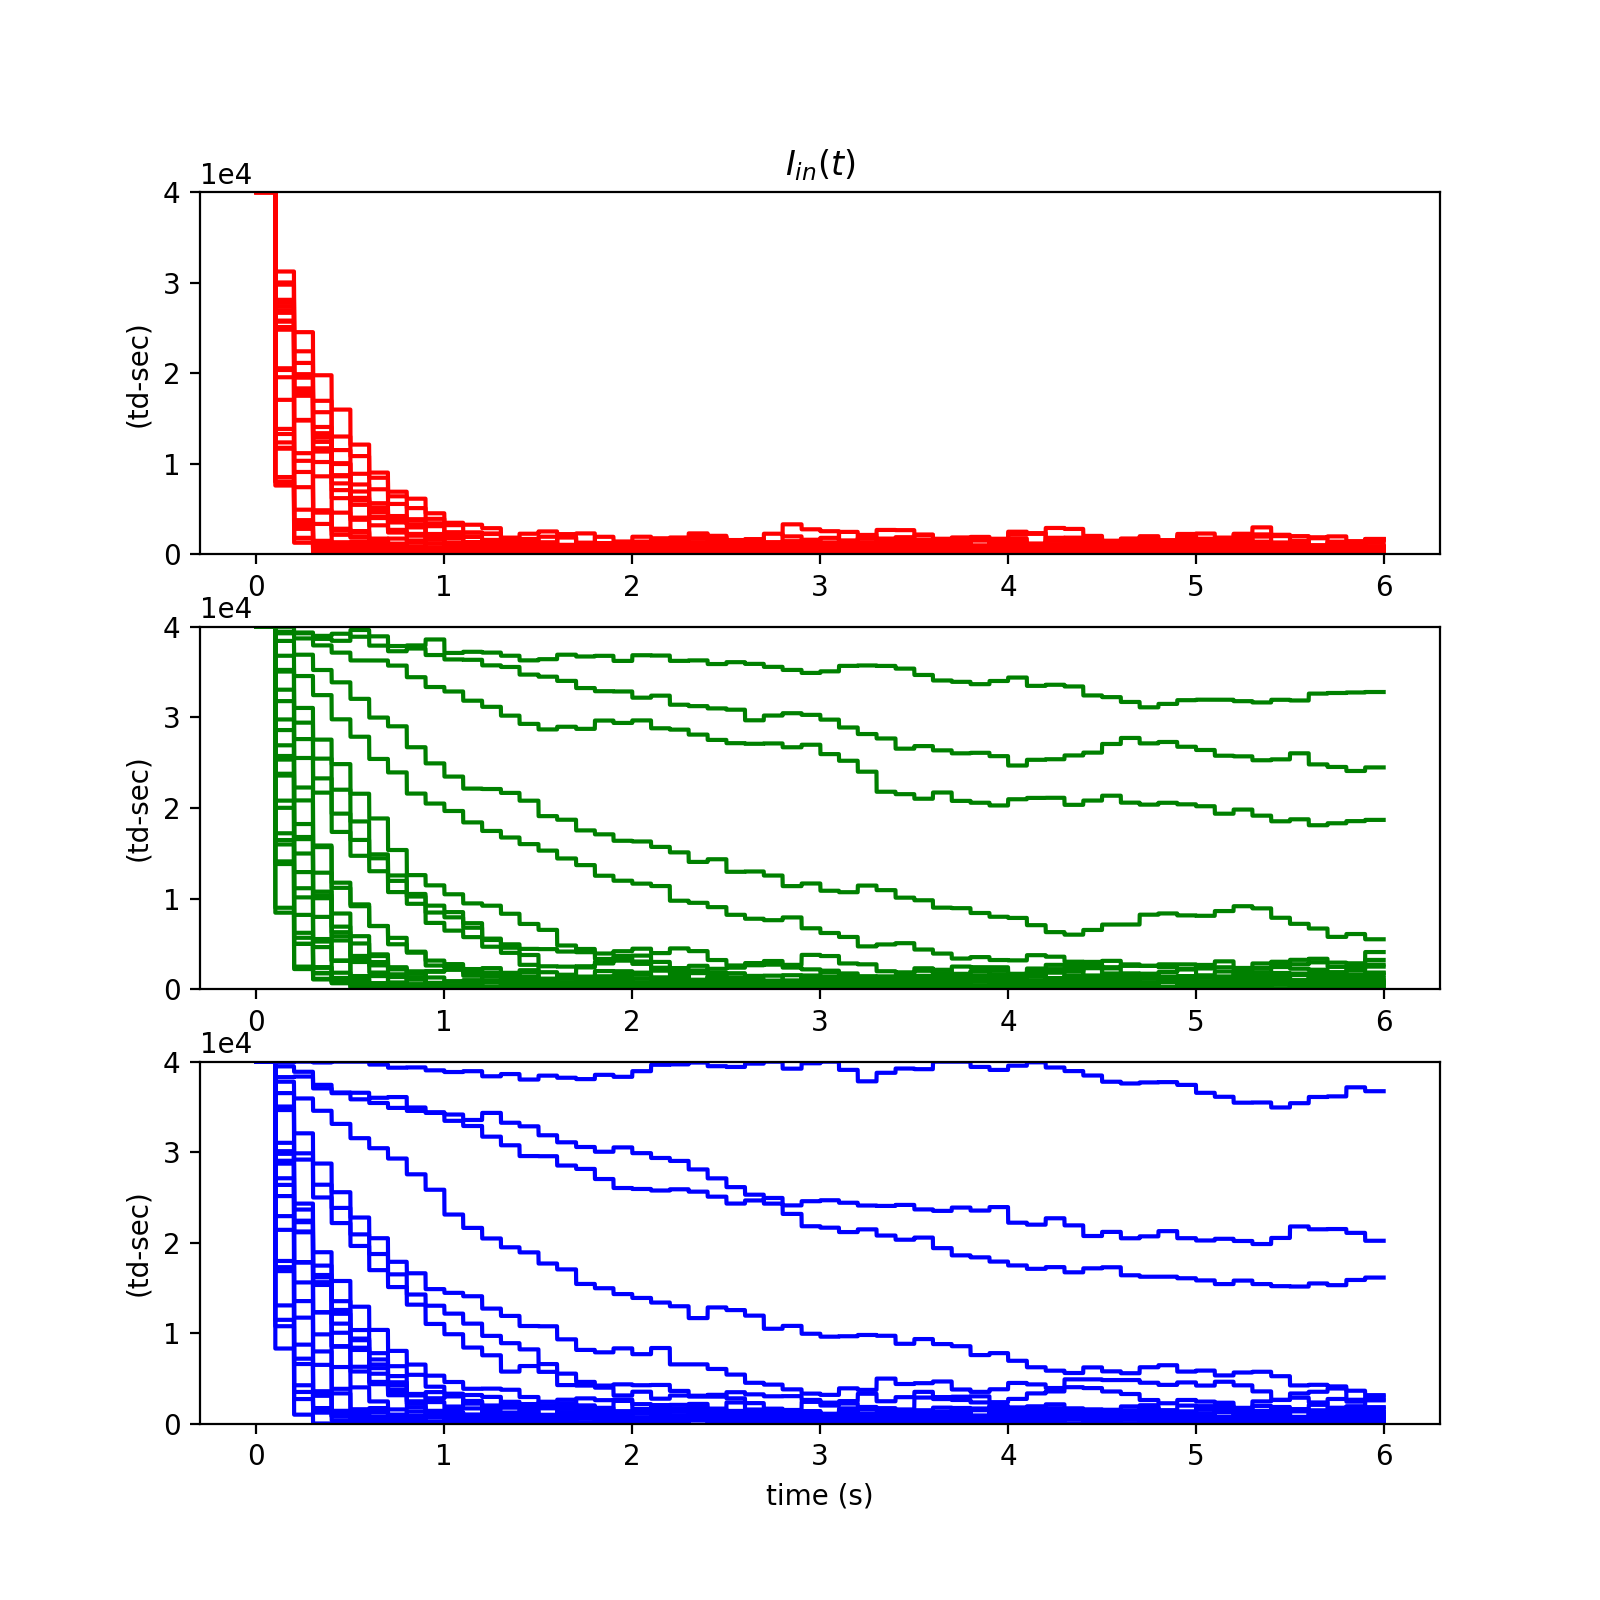

<IPython.core.display.Javascript object>


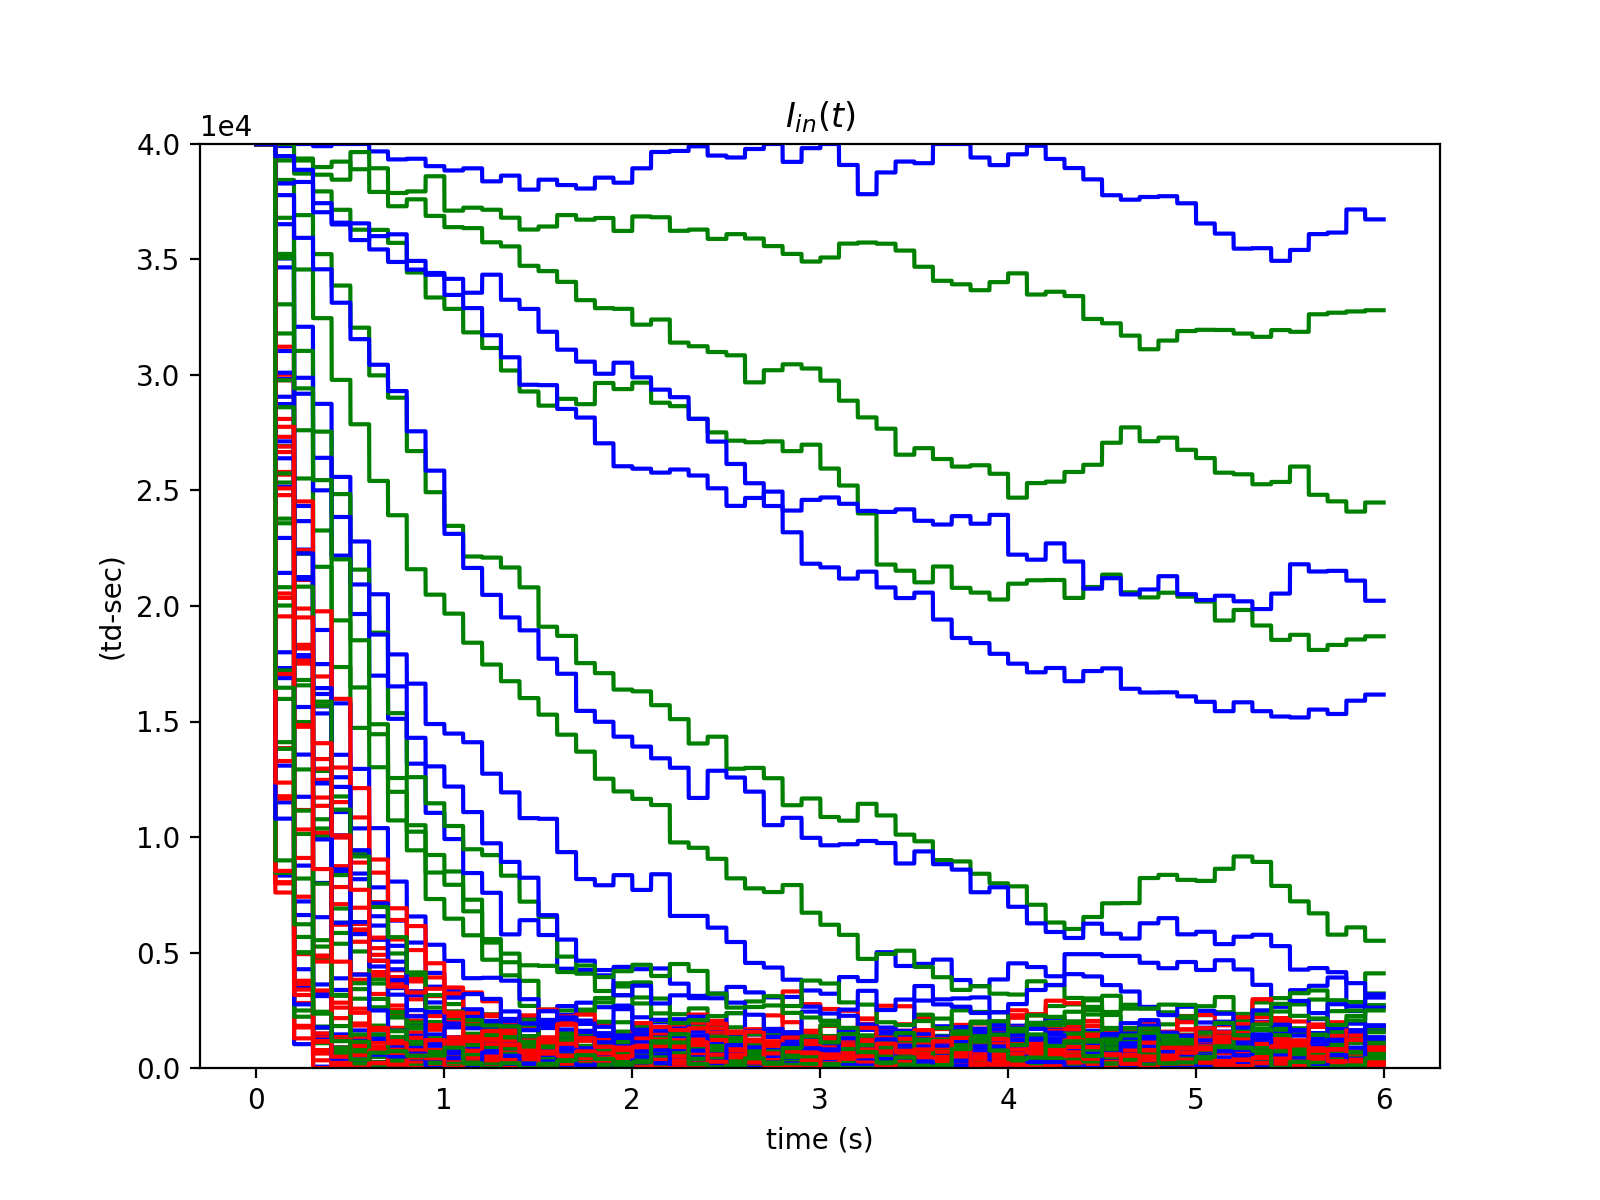

Text(0.5, 0, 'time (s)')

In [10]:
# qt, wx, gtk, osx, tk, empty uses default
%matplotlib notebook 

ylim = 4e4

plt.figure(figsize=(8, 8), dpi=100)
plt.subplot(3,1,1)
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
for i in range(n_trials):
    plt.plot(t, L_Iin_all[i,:-1],c='r')
plt.title('$I_{in}(t)$')
plt.ylim([0, ylim])
plt.ylabel('(td-sec)')

plt.subplot(3,1,2)
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
for i in range(n_trials):
    plt.plot(t, M_Iin_all[i,:-1],c='g')
plt.ylim([0, ylim])
plt.ylabel('(td-sec)')

plt.subplot(3,1,3)
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
for i in range(n_trials):
    plt.plot(t, S_Iin_all[i,:-1],c='b')
plt.ylim([0, ylim])
plt.ylabel('(td-sec)')
plt.xlabel('time (s)')

plt.figure(figsize=(8, 6), dpi=100)
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
for i in range(n_trials):
    plt.plot(t, L_Iin_all[i,:-1],c='r')
    plt.plot(t, M_Iin_all[i,:-1],c='g')
    plt.plot(t, S_Iin_all[i,:-1],c='b')
    
plt.title('$I_{in}(t)$')
plt.ylim([0, ylim])
plt.ylabel('(td-sec)')
plt.xlabel('time (s)')

## Run experiment with $\alpha_{scatter}$ estimation

In [11]:
# simulation settings
n_trials = 25

L_Iin_all, L_Iout_all, L_pt_all, L_resid_all = [],[],[],[]
M_Iin_all, M_Iout_all, M_pt_all, M_resid_all = [],[],[],[]
S_Iin_all, S_Iout_all, S_pt_all, S_resid_all = [],[],[],[]

for i in range(n_trials):
    L_Iin, L_Iout, L_pt, t, L_resid = simulate_experiment(a_cone = 0.2,  account_for_a_scatter=True)
    M_Iin, M_Iout, M_pt, t, M_resid = simulate_experiment(a_cone = 0.01, account_for_a_scatter=True)
    S_Iin, S_Iout, S_pt, t, S_resid = simulate_experiment(a_cone = 1e-4, account_for_a_scatter=True)
    
    append_four(L_Iin, L_Iout, L_pt, L_resid, L_Iin_all, L_Iout_all, L_pt_all, L_resid_all)
    append_four(M_Iin, M_Iout, M_pt, M_resid, M_Iin_all, M_Iout_all, M_pt_all, M_resid_all)
    append_four(S_Iin, S_Iout, S_pt, S_resid, S_Iin_all, S_Iout_all, S_pt_all, S_resid_all)
    
L_Iin_all, L_Iout_all, L_pt_all, L_resid_all = convert_to_np(L_Iin_all, L_Iout_all, L_pt_all, L_resid_all)
M_Iin_all, M_Iout_all, M_pt_all, M_resid_all = convert_to_np(M_Iin_all, M_Iout_all, M_pt_all, M_resid_all)
S_Iin_all, S_Iout_all, S_pt_all, S_resid_all = convert_to_np(S_Iin_all, S_Iout_all, S_pt_all, S_resid_all)
    
print('L-cone intrinsic residual ~ mean: %0.2e ~ std: %0.2e' % 
      (np.mean(L_resid_all), np.std(L_resid_all)))
print('M-cone intrinsic residual ~ mean: %0.2e ~ std: %0.2e' % 
      (np.mean(M_resid_all), np.std(M_resid_all)))
print('S-cone intrinsic residual ~ mean: %0.2e ~ std: %0.2e' % 
      (np.mean(S_resid_all), np.std(S_resid_all)))

L-cone intrinsic residual ~ mean: 8.30e-04 ~ std: 5.83e-04
M-cone intrinsic residual ~ mean: 1.03e-03 ~ std: 6.65e-04
S-cone intrinsic residual ~ mean: 7.88e-04 ~ std: 7.56e-04


<IPython.core.display.Javascript object>


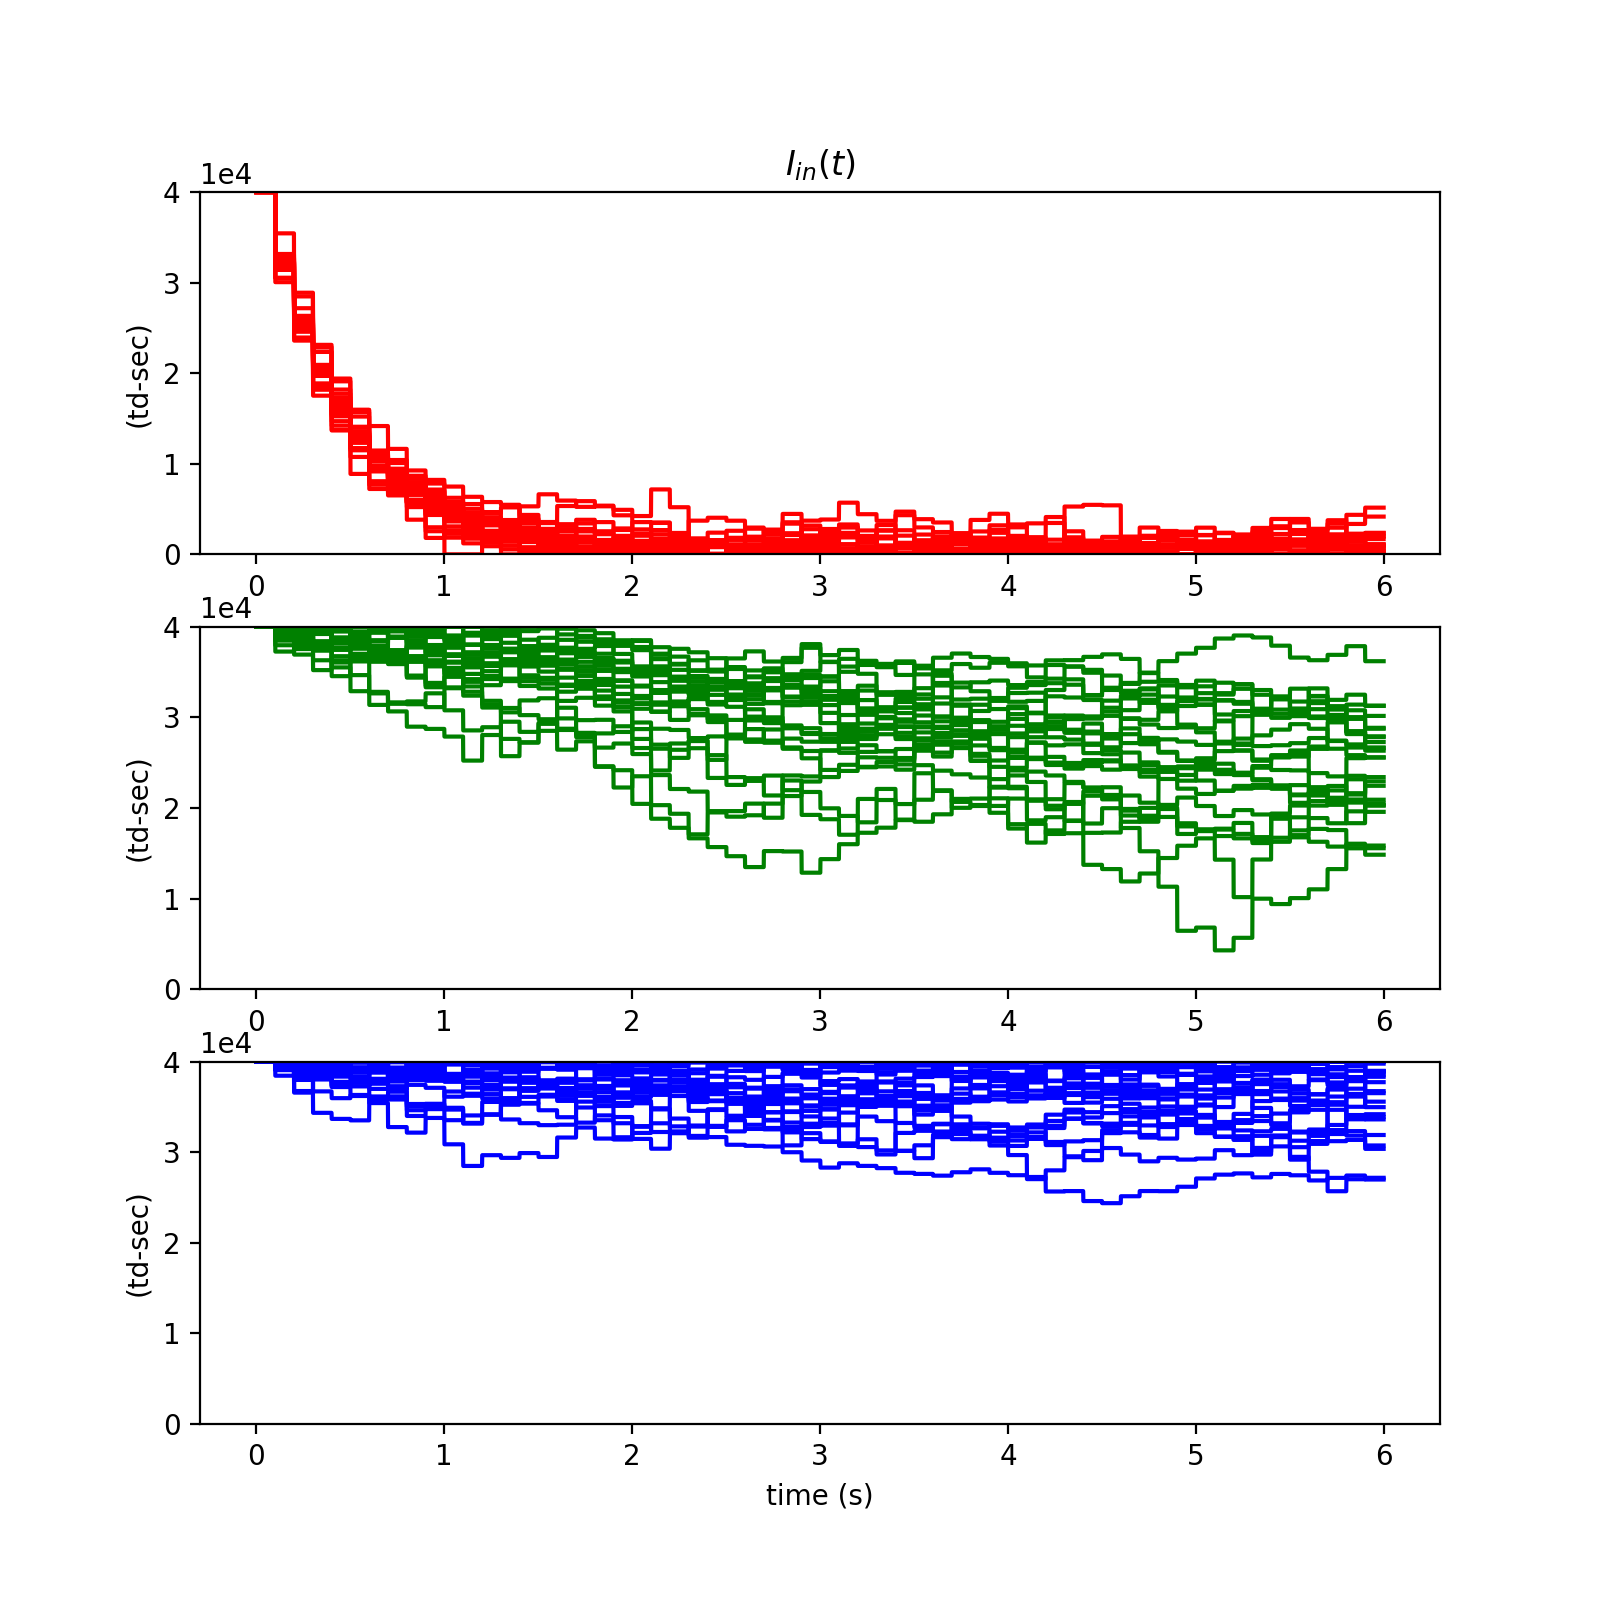

<IPython.core.display.Javascript object>


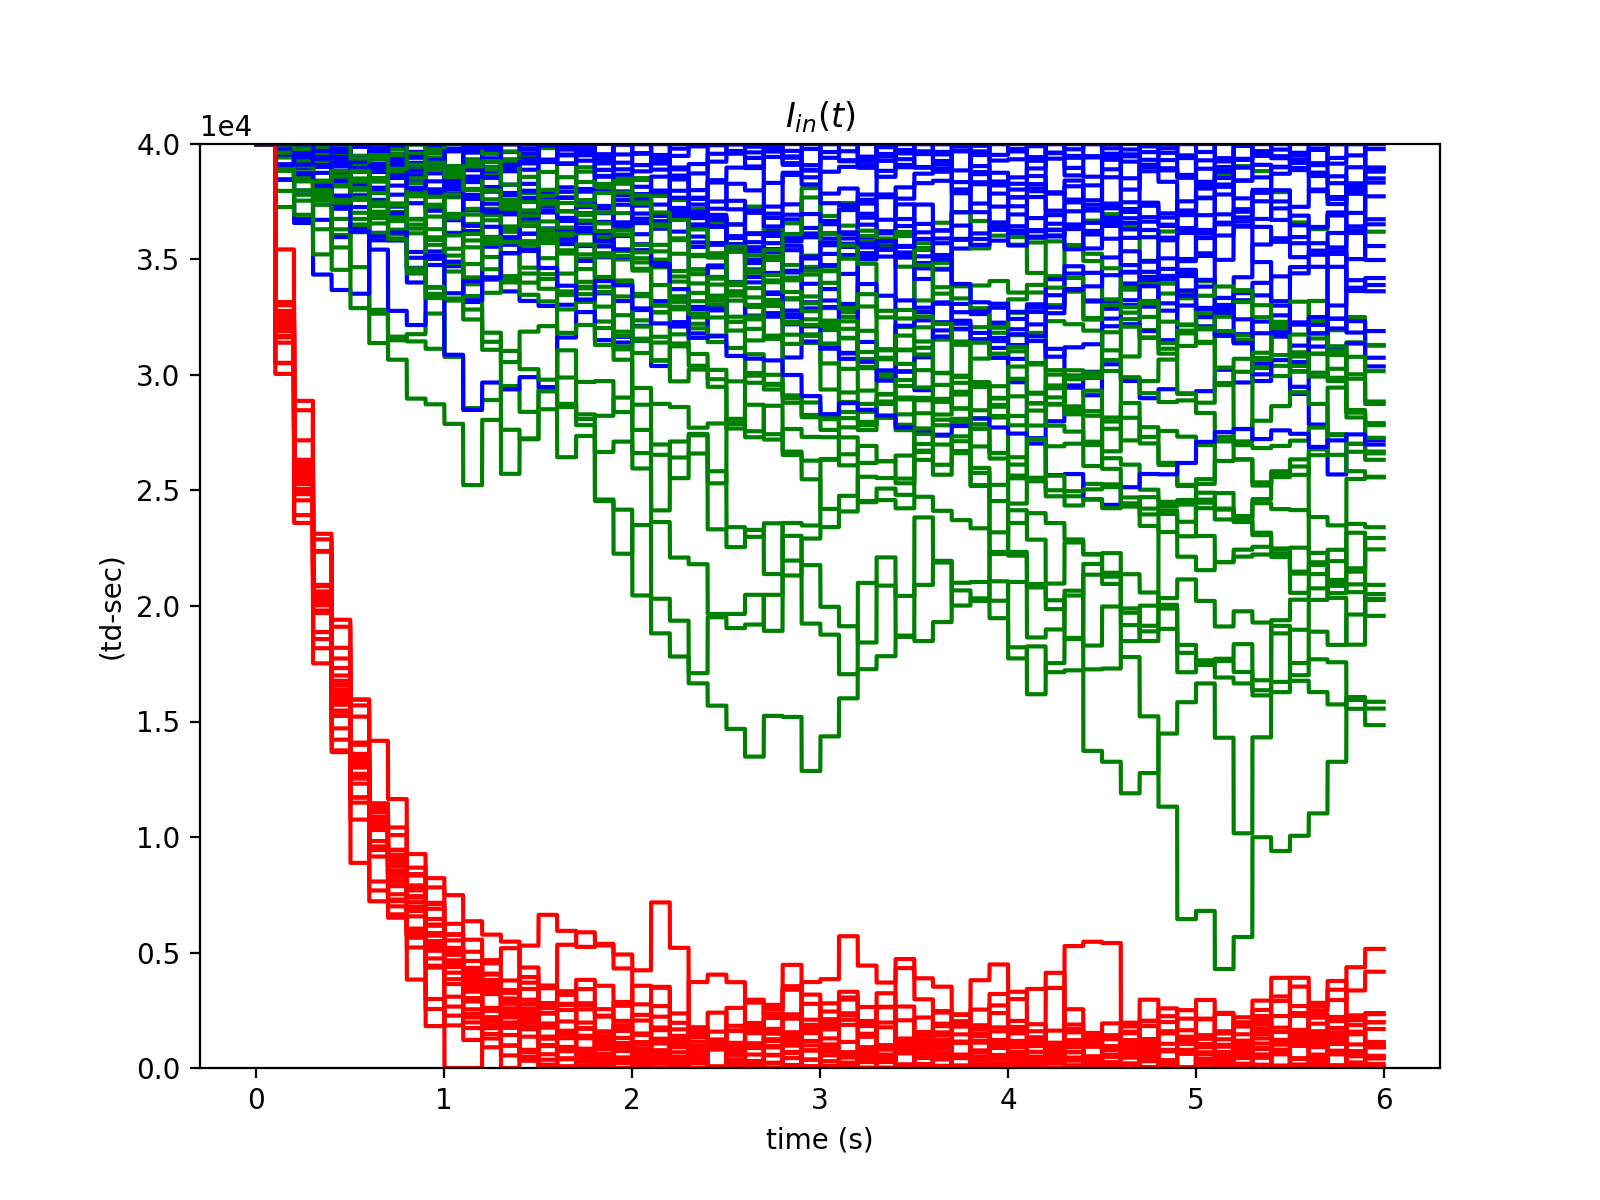

Text(0.5, 0, 'time (s)')

In [12]:
# qt, wx, gtk, osx, tk, empty uses default
%matplotlib notebook 

ylim = 4e4

plt.figure(figsize=(8, 8), dpi=100)
plt.subplot(3,1,1)
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
for i in range(n_trials):
    plt.plot(t, L_Iin_all[i,:-1],c='r')
plt.title('$I_{in}(t)$')
plt.ylim([0, ylim])
plt.ylabel('(td-sec)')

plt.subplot(3,1,2)
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
for i in range(n_trials):
    plt.plot(t, M_Iin_all[i,:-1],c='g')
plt.ylim([0, ylim])
plt.ylabel('(td-sec)')

plt.subplot(3,1,3)
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
for i in range(n_trials):
    plt.plot(t, S_Iin_all[i,:-1],c='b')
plt.ylim([0, ylim])
plt.ylabel('(td-sec)')
plt.xlabel('time (s)')

plt.figure(figsize=(8, 6), dpi=100)
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
for i in range(n_trials):
    plt.plot(t, L_Iin_all[i,:-1],c='r')
    plt.plot(t, M_Iin_all[i,:-1],c='g')
    plt.plot(t, S_Iin_all[i,:-1],c='b')
    
plt.title('$I_{in}(t)$')
plt.ylim([0, ylim])
plt.ylabel('(td-sec)')
plt.xlabel('time (s)')

### In the above model, we see that correcting for the inherent scatter made the input image diverge from the other cones! This should allow us to cluster the curves and infer L-types easily.

<IPython.core.display.Javascript object>


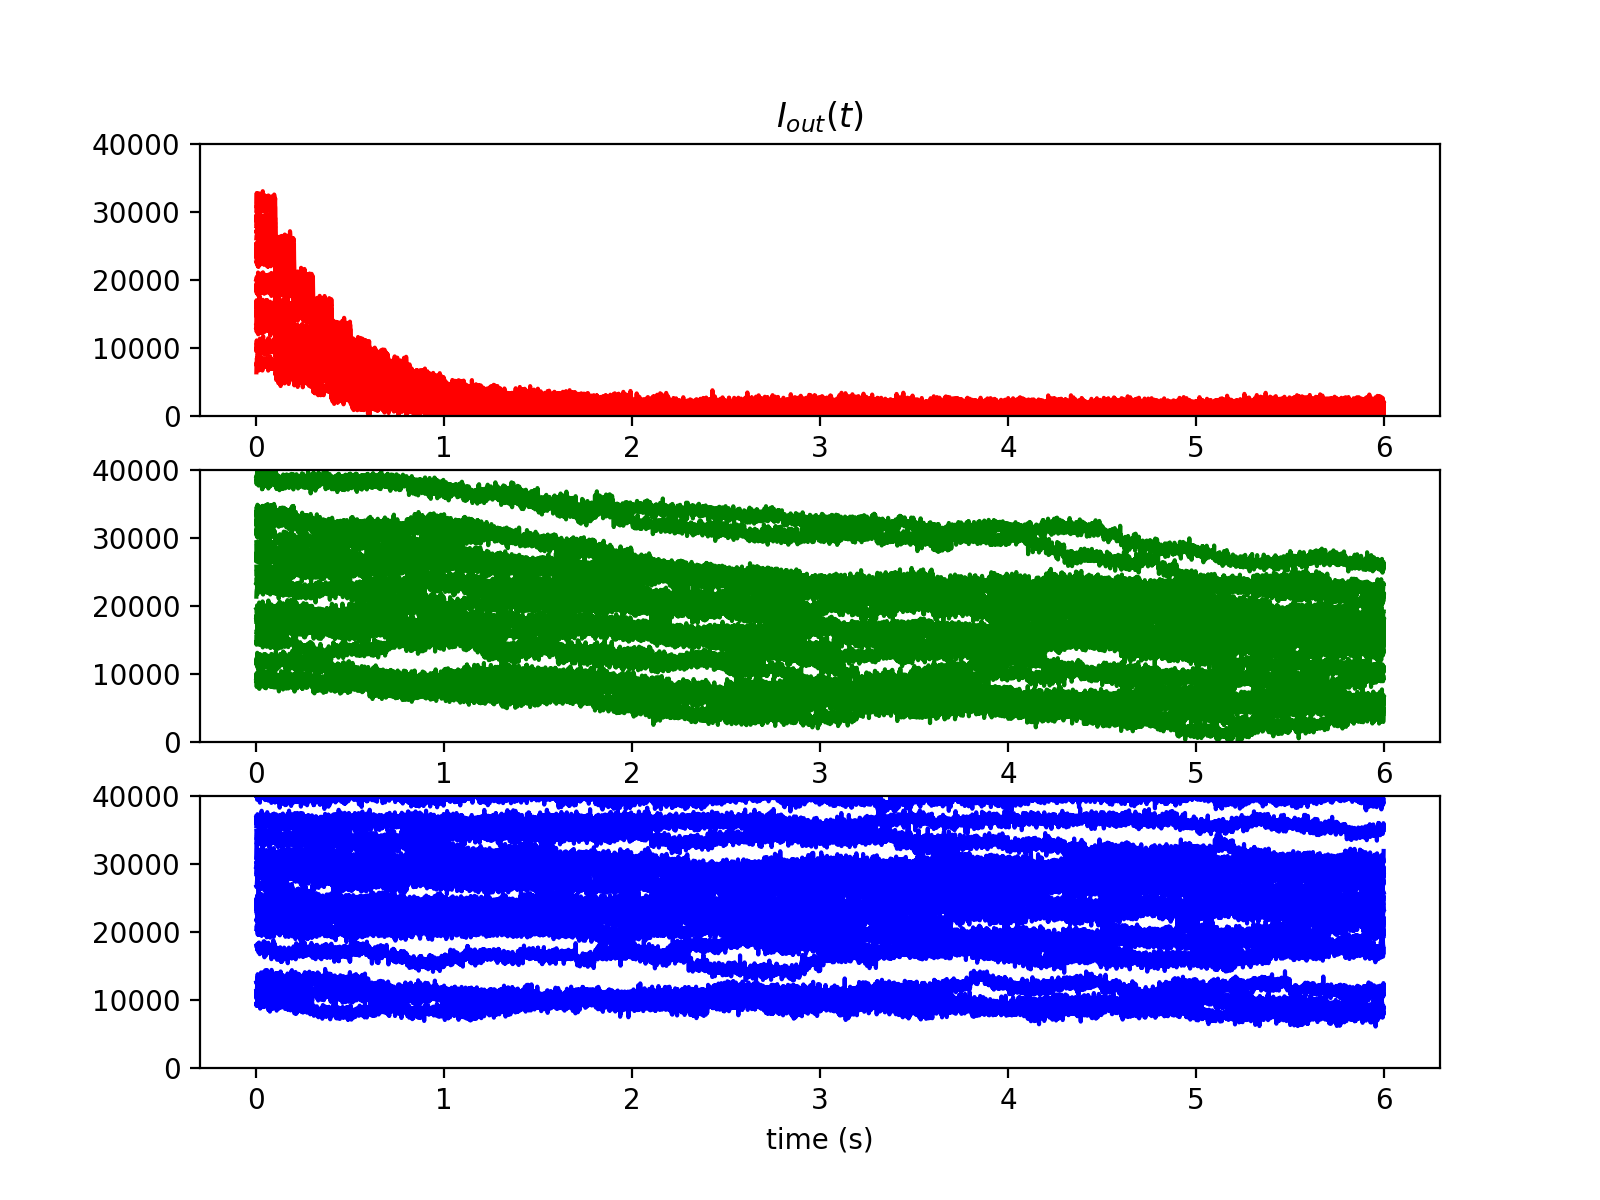

Text(0.5, 0, 'time (s)')

In [13]:
%matplotlib notebook

plt.figure(figsize=(8, 6), dpi=100)
plt.subplot(3,1,1)
for i in range(n_trials):
    plt.plot(t, L_Iout_all[i,:],c='r')
plt.ylim([0, 4e4])
plt.title('$I_{out}(t)$')

plt.subplot(3,1,2)
for i in range(n_trials):
    plt.plot(t, M_Iout_all[i,:],c='g')
plt.ylim([0, 4e4])
    
plt.subplot(3,1,3)
for i in range(n_trials):
    plt.plot(t, S_Iout_all[i,:],c='b')
plt.ylim([0, 4e4])
plt.xlabel('time (s)')